In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Reinink, Luc (1068948)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I tested different optimizers and learning rates, Adagrad with 0.01 lr yielded the best and most stable result. I started with 3072 nodes in the first layer yielding over 80% accuracy. I then lowered the node amount by half until the result became worse and stopped at the lowest good amount. The end performance is good, 84% accuracy on the validation set, and it seems stable.  (length: 380)



Max val score: 83.63%


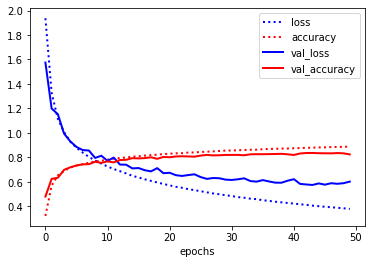

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 384)               1180032   
_________________________________________________________________
dense_5 (Dense)              (None, 192)               73920     
_________________________________________________________________
dense_6 (Dense)              (None, 96)                18528     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                970       
Total params: 1,273,450
Trainable params: 1,273,450
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_1():
    model = models.Sequential()
    start_nodes = 384
    model.add(layers.Reshape

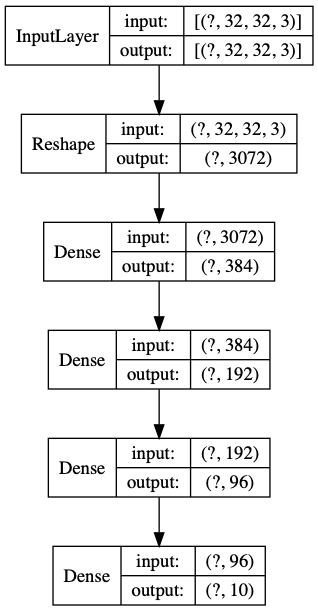

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

I changed the reshaping for the new 32x32x1 shape. I did not change the model otherwise. This yields almost identical results, as expected, since only non-essential information is removed. It can manage this with much fewer parameters, which is good. We can therefore say that this model is more efficient, which is better. Just like before, the model is pretty stable.  (length: 371)



Max val score: 84.50%


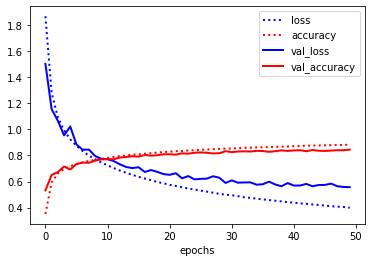

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 384)               393600    
_________________________________________________________________
dense_13 (Dense)             (None, 192)               73920     
_________________________________________________________________
dense_14 (Dense)             (None, 96)                18528     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                970       
Total params: 487,018
Trainable params: 487,018
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_2():
    model = models.Sequential()
    start_nodes = 384
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(start_nodes, activation='relu'))
    model.add(layers.Dense(start_nodes / 2, activation='relu'))
    model.add(layers.Dense(start_nodes / 4, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    optimizer = keras.optimizers.Adagrad(learning_rate=0.01)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

I tried L1 and L2 regularization, small values resulted in similar results but slower convergence, larger values worsened results. Using dropout gave the same result, but the graphs lines became much smoother, indicating a more stable model. Batch normalization resulted in much quicker convergence, but lost about 5% accuracy, which was not worth it, so I only kept dropout  (length: 376)



Max val score: 85.32%


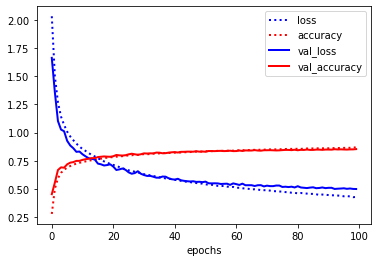

def build_model_1_3():
    model = models.Sequential()
    start_nodes = 384
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(start_nodes, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(start_nodes / 2, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(start_nodes / 4, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='softmax'))

    optimizer = keras.optimizers.Adagrad(learning_rate=0.01)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

I first tried 2, 3, 4 and 5 layers with different amounts of nodes and kept the smallest that performed well considering under/overfitting. MaxPooling made convergence slower, but yielded a much smoother graph. I tried MaxPooling in different layers, and after 1 and 2 tested best. Very small L1 and/or L2 regularization decreased performance slightly and increasing it made it worse. Adagrad gave the best performance of the optimizers. Dropout in the last layers made the graph much smoother and 0.4 tested best. The model is nice and converges quickly. It's stable with nice smooth lines, and a good performance of >92%.  (length: 625)



Max val score: 92.50%


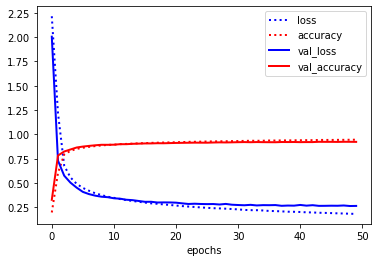

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)              

def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
        
    optimizer = keras.optimizers.Adagrad(learning_rate=0.01)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model



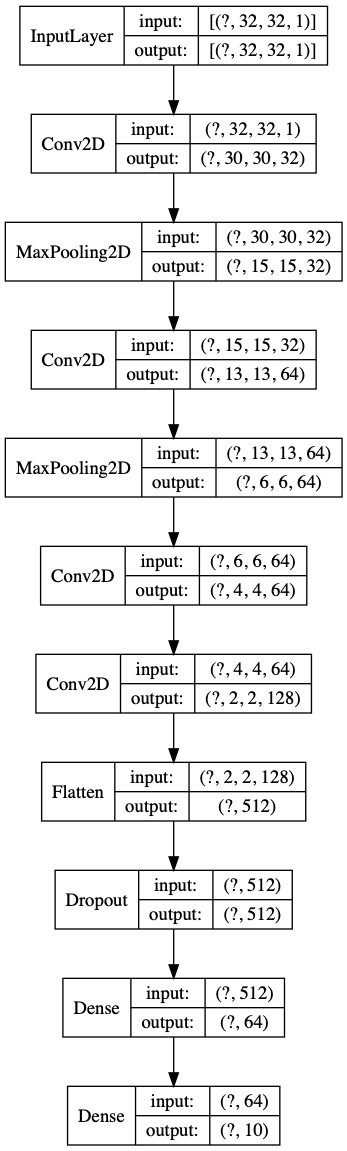

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

I tried every change individually with 1986 steps per epoch. Zoom, shifts and shear range worked well, about 2% less accuracy. Rotation and horizontal flip were worse about 3-4%. Brightness range and samplewise_std_normalization were terrible, up to 50% loss. I then combined the good ones and used the generator for more steps improving the accuracy beyond the levels of 2.1.  (length: 378)



Max val score: 93.43%


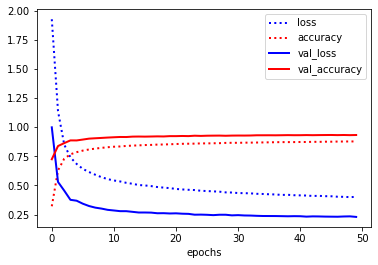


train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    )


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

7 is confused with 1 most frequently (relatively) and 3 and 5 are also often confused. This is logical since these numbers look most alike. There are also some less logical confusions, like 3 and 2. When visualising these, the confusion is expected since due to the blurry images, the difference can be hard to see. In many cases, a 3 next to a 2 occurs, which explains confusion.  (length: 382)

Test score: 0.93%


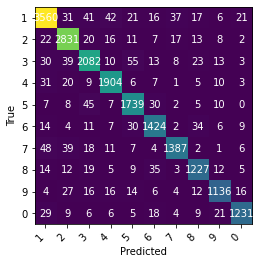

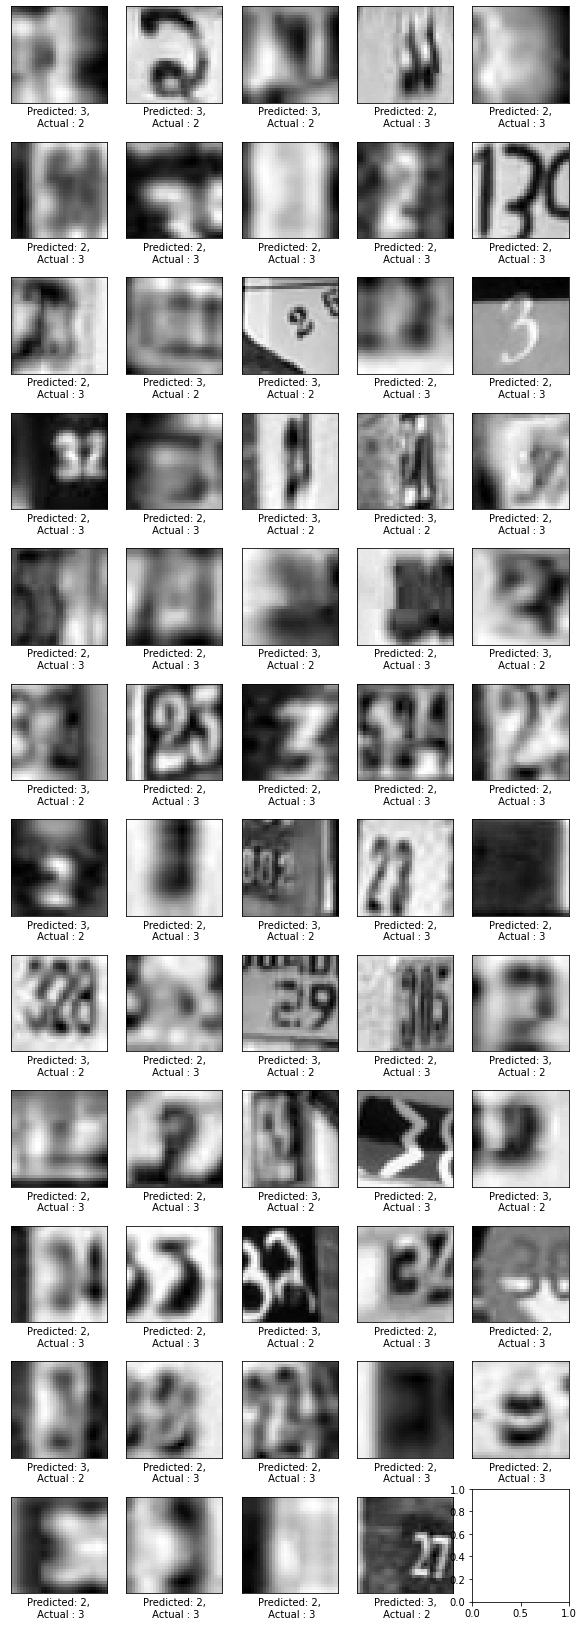

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

The first layer still clearly shows the number, each activation focussing on a different aspect of the number. L1 0 focusses on the left edges, and L1 16 on the right edges. L1 14 focuses a bit on the bottom edges of numbers. Layer 3 is more abstract, focussing on straight and curved patterns in different orientations. It looks like L3 62 focuses more on the spaces in the 8.  (length: 379)



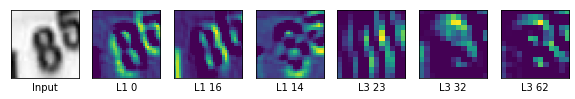

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

def plot_activation_map(model, img):
    f, (ax1, ax2) = plt.subplots(1, 2)

    eight_output = model.output[:, 7]

    last_conv_layer = model.get_layer('conv2d_27')
    
    grads = K.gradients(eight_output, last_conv_layer.output)[0]

    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([X_test_gs[0:1]])

    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    ax1.matshow(heatmap)
    ax1.set_xlabel('Activation map')

    heatmap = cv2.resize(heatmap, (X_test_gs[0].shape[1], X_test_gs[0].shape[0]))

    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * 0.4 + img

    ax2.imshow(s

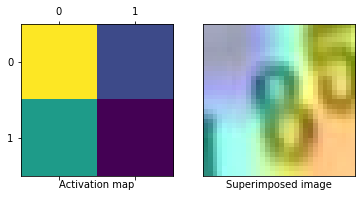

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

The model gets about 79% accuracy, which is not good. Training takes very long, because 2 conv. layers are trainable, resulting in a lot of params. A small L1 regularizer improved performance, L2 did not. Dropout also improved performance a bit. I had to set the learning rate very low to not break the already learned parameters. A larger dense layer generalised worse.  (length: 372)



Max val score: 79.11%


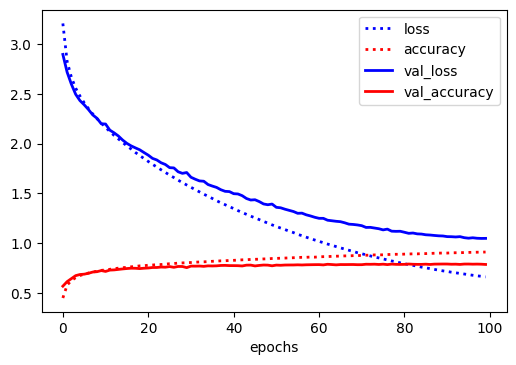

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)       

def build_model_4_1():
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    model = models.Sequential()
    for layer in vgg16.layers:
        model.add(layer)
    
    for layer in model.layers:
        layer.trainable = False

    model.layers[-1].trainable = True
    model.layers[-2].trainable = True
    model.layers[-3].trainable = True

    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(10, activation='softmax'))
        
    optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model



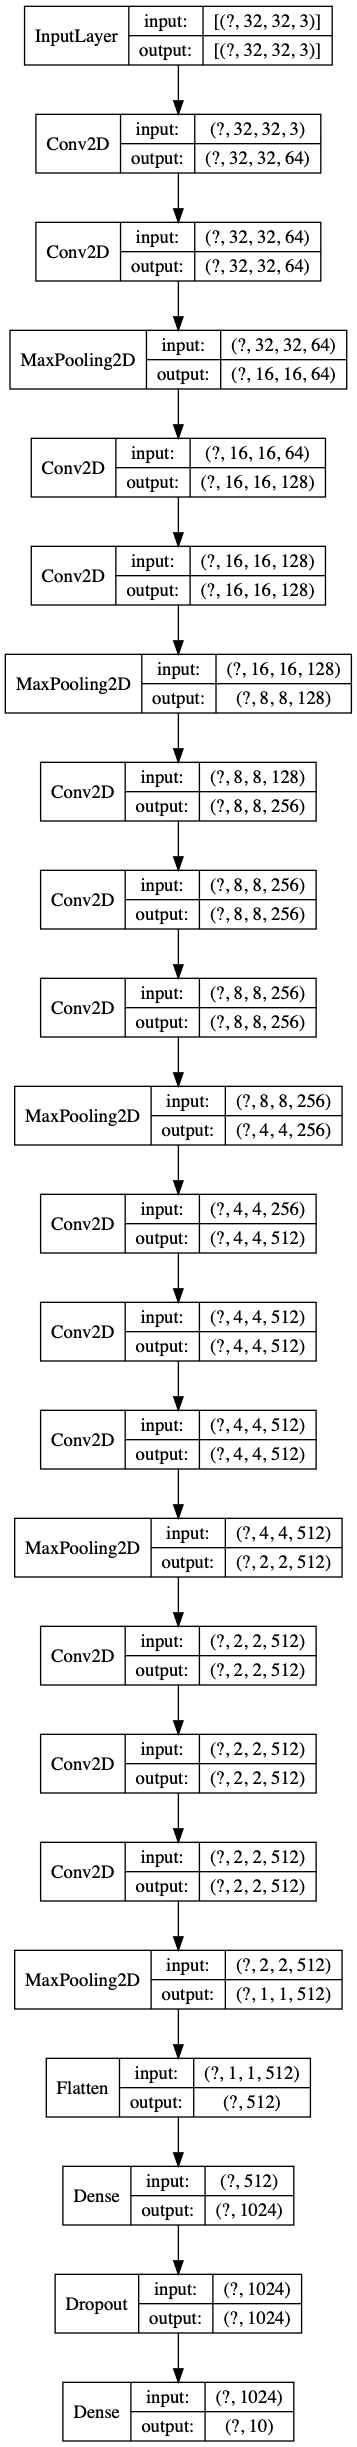

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

I removed the last three layers of 4_1's model but kept the Flatten to make the data fit the classifier. I ran the data through it, and stored the embeddings. I tried Ridge, LinearRegression and Lasso, but DecisionTreeClassifier performed best with the embeddings. This strategy shows extreme overfitting, 97% train and 64% test accuracy, it's not a  replacement for deep learning.  (length: 383)

Pipeline(steps=[('clf', DecisionTreeClassifier(max_depth=20))])
def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    model_4_1 = load_model_from_file(base_dir, "model_4_1")
    model = models.Sequential()
    for layer in model_4_1.layers[:-3]:
        model.add(layer)

    optimizer = keras.optimizers.Adagrad(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    train_embedding = model.predict(X_train)
    test_embedding = model.predict(X_test)
    store_embed

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 18.98 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
